In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
dataset_dir = "/content/drive/My Drive/Colab Notebooks/Dataset/car_data/car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

In [0]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Lần %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Kết thúc')
    return model, losses, accuracies, test_accuracies

In [0]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Độ chính xác của mô hình cho test images: %d %%' % (
        test_acc))
    return test_acc

In [6]:
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.1MB/s]


In [7]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Test acc')

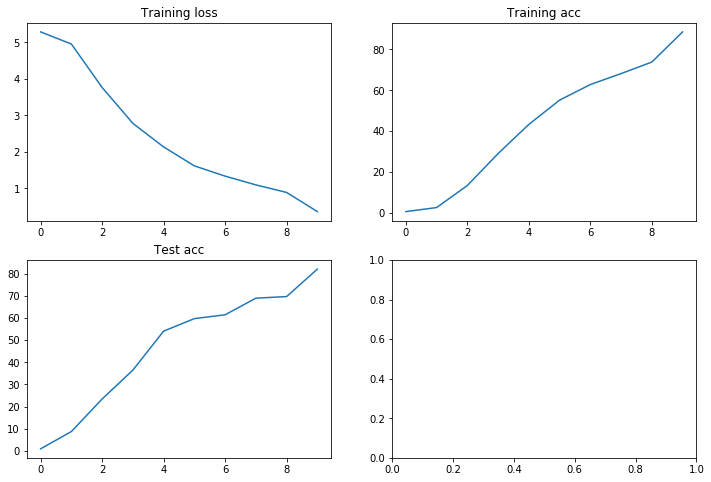

In [0]:

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

In [0]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [0]:
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Audi A5 Coupe 2012/03808.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

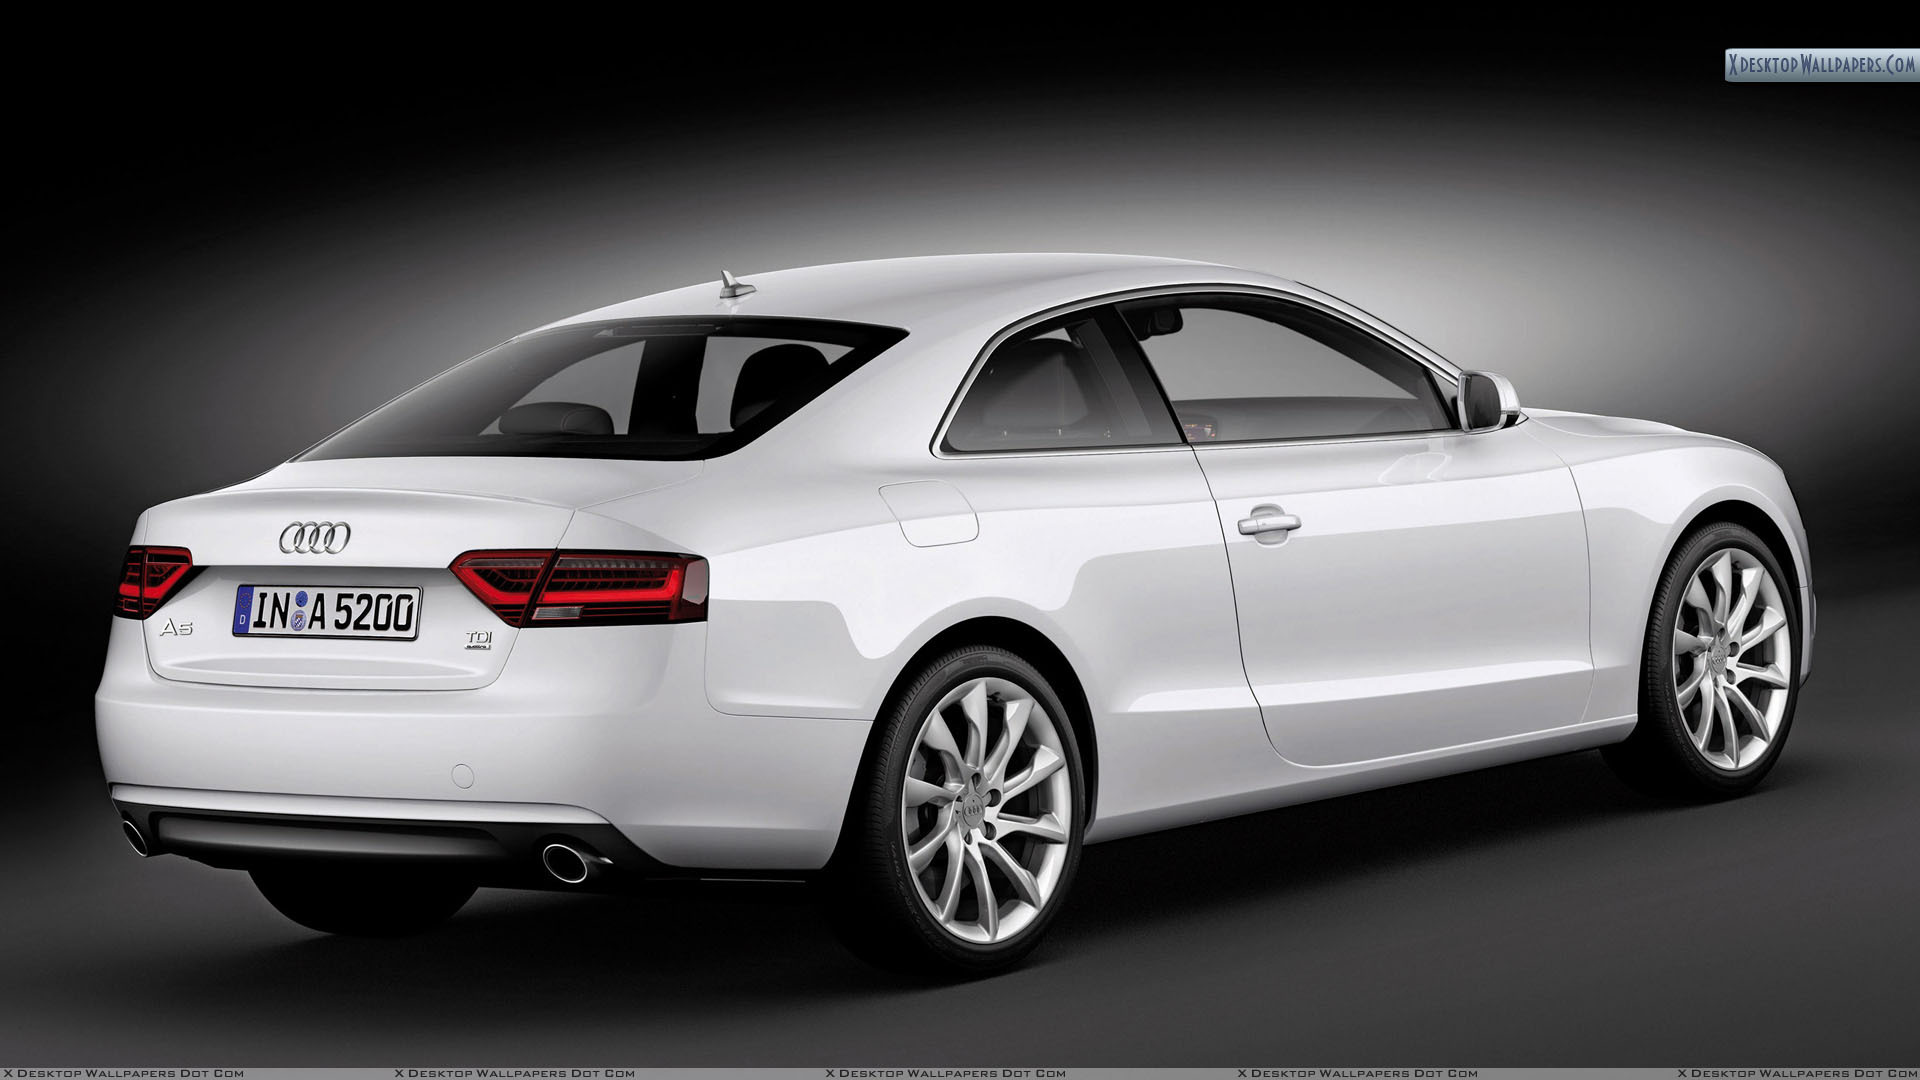

Lamborghini Aventador Coupe 2012 confidence:  1.7452913522720337


In [12]:
# get class name
display(Image.open(dataset_dir+"test/Audi A5 Coupe 2012/03808.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())